In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
# Figure out how to import regularizers
from tensorflow.keras import regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [3]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2021-01-17 09:17:57--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 172.217.214.128, 108.177.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-01-17 09:17:57 (142 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [5]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len - 1)) # Your Embedding Layer
model.add(Bidirectional(LSTM(150, return_sequences=True))) # An LSTM Layer
model.add(Dropout(0.2)) # A dropout layer
model.add(LSTM(100)) # Another LSTM Layer
model.add(Dense(total_words / 2, activation='relu', kernel_regularizer=regularizers.l2(0.01))) # A Dense Layer including regularizers
model.add(Dense(total_words, activation='softmax')) # A Dense Layer
# Pick an optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Pick a loss function and an optimizer
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1605)              162105    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
____________________________________________

In [6]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 15s 12ms/step - loss: 7.3475 - accuracy: 0.0213
Epoch 2/100
484/484 [==============================] - 6s 12ms/step - loss: 6.4847 - accuracy: 0.0221
Epoch 3/100
484/484 [==============================] - 6s 12ms/step - loss: 6.3835 - accuracy: 0.0224
Epoch 4/100
484/484 [==============================] - 6s 12ms/step - loss: 6.2816 - accuracy: 0.0308
Epoch 5/100
484/484 [==============================] - 6s 12ms/step - loss: 6.1659 - accuracy: 0.0356
Epoch 6/100
484/484 [==============================] - 6s 12ms/step - loss: 6.1058 - accuracy: 0.0393
Epoch 7/100
484/484 [==============================] - 6s 12ms/step - loss: 6.0171 - accuracy: 0.0410
Epoch 8/100
484/484 [==============================] - 6s 12ms/step - loss: 5.9289 - accuracy: 0.0452
Epoch 9/100
484/484 [==============================] - 6s 12ms/step - loss: 5.8046 - accuracy: 0.0542
Epoch 10/100
484/484 [==============================] - 6s 12ms/step - loss: 5.69

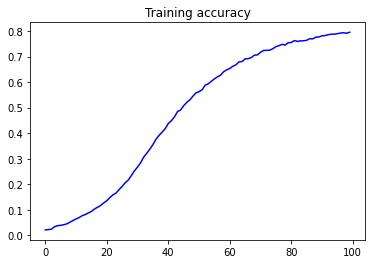

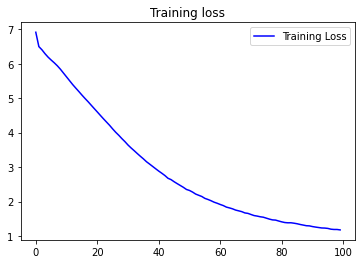

In [7]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [8]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Help me Obi Wan Kenobi, you're my only hope be read his worth is new to me now live alone lend me 'tis thee forth 'will ' held scorn to ride razed grow back hath grows him allay'd allay'd told of 'will days alone held should words forbid back oppress'd lived afloat there days new parts to thee my sight from thee were outworn tell days lust new dearer sadly cherish cherish quite place releasing live days so best lived so dearly ' should not should bear thee bright staineth deem'd kill'd moan laws men days held hence shown blind end dost find room tender'd commend scorn of woe
